# 設定

In [40]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pylab import rcParams
import matplotlib.font_manager as fm
import matplotlib.ticker as ptick   # ライブラリをインポートする。
import seaborn as sns
import scipy as sp
import os
from matplotlib.gridspec import GridSpec
import tensorflow as tf
import tensorflow_probability as tfp
tfd, tfb = tfp.distributions, tfp.bijectors
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
%matplotlib inline

In [41]:
# plt.rcParams['font.family'] ='Arial' #使用するフォント
plt.rcParams['font.family'] = 'DejaVu Serif' #_ 日本語入力の際はIPAexGothicを用いる

fontsize = 25
plt.rcParams['font.size'] = fontsize #フォントの大きさ
plt.rcParams['xtick.labelsize'] = fontsize #x軸の目盛りのフォントの大きさ
plt.rcParams['ytick.labelsize'] = fontsize #y軸の目盛りのフォントの大きさ
plt.rcParams['axes.labelsize'] = fontsize #軸の名前のフォントの大きさ

plt.rcParams['xtick.major.size'] = 6.0 #x軸主目盛り線の線の長さ
plt.rcParams['ytick.major.size'] = 6.0 #y軸主目盛り線の長さ
plt.rcParams['ytick.minor.size'] = 5.0 #y軸補助目盛り線の長さ
plt.rcParams['xtick.major.width'] = 1.5 #x軸主目盛り線の線幅
plt.rcParams['ytick.major.width'] = 1.5 #y軸主目盛り線の線幅
plt.rcParams['ytick.minor.width'] = 1.2 #y軸補助目盛り線の線幅

plt.rcParams['axes.linewidth'] = 1.5 # 軸の線幅edge linewidth。囲みの太さ
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['xtick.top'] = True
plt.rcParams['ytick.right'] = True

rcParams['figure.figsize'] = 10, 5#画像の大きさ



# Cov_Matrix を指定

In [42]:
var_x = 1
var_y = 2
linspace = 10000

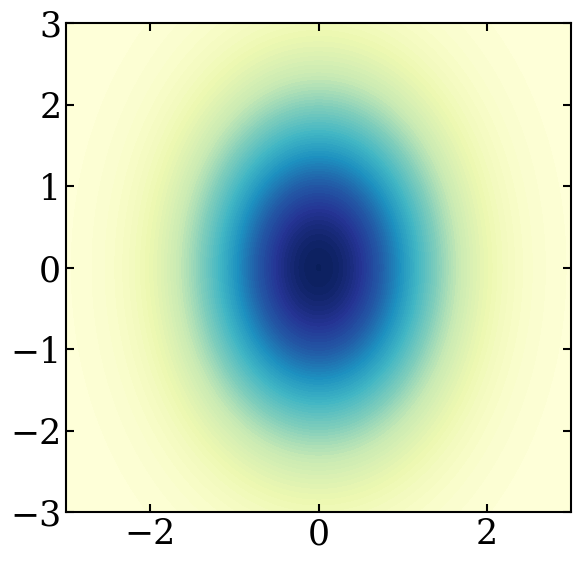

In [43]:
Cov_Matrix = np.array(
    [[var_x,0
    ,0, var_y] for i in range(linspace)], dtype=np.float64
).reshape(linspace,2,2)
mean = np.array([0., 0.])
cov = np.array([[Cov_Matrix[0][0][0],Cov_Matrix[0][1][0]],[Cov_Matrix[0][1][0],Cov_Matrix[0][1][1]]])
nd = tfd.MultivariateNormalTriL(loc=mean, scale_tril=tf.linalg.cholesky(cov))

x, y = np.linspace(-3,3,1000), np.linspace(-3,3,1000)
X1, X2 = np.meshgrid(x, y)
Z = nd.prob(np.dstack((X1, X2)))

fig = plt.figure(figsize=(8, 8))

gs = GridSpec(2, 2, width_ratios=[8,2], height_ratios=[8,2])

ax = plt.subplot(gs[0])
con = ax.contourf(X1, X2, Z, 100, cmap='YlGnBu')
ax.set(axisbelow=False)
ax.autoscale(tight=True)
# fig.suptitle('Gaussian Distribution')

plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()


In [44]:
translation = np.linspace(0, 10, linspace)
Cov_Mat_inv = np.linalg.inv(Cov_Matrix)
norm = translation
t_x = np.array([[i,0] for i in translation])
t_y = np.array([[0,i] for i in translation])

KL_x = np.zeros(linspace)
for i in range(linspace):
    KL_x[i] = 0.5*(t_x[i]@Cov_Mat_inv[i]@t_x[i])

KL_y = np.zeros(linspace)
for i in range(linspace):
    KL_y[i] = 0.5*(t_y[i]@Cov_Mat_inv[i]@t_y[i])

data = pd.DataFrame(data = {'translation':translation, 'Wasserstein':norm, 'KL_x':KL_x, 'KL_y':KL_y})

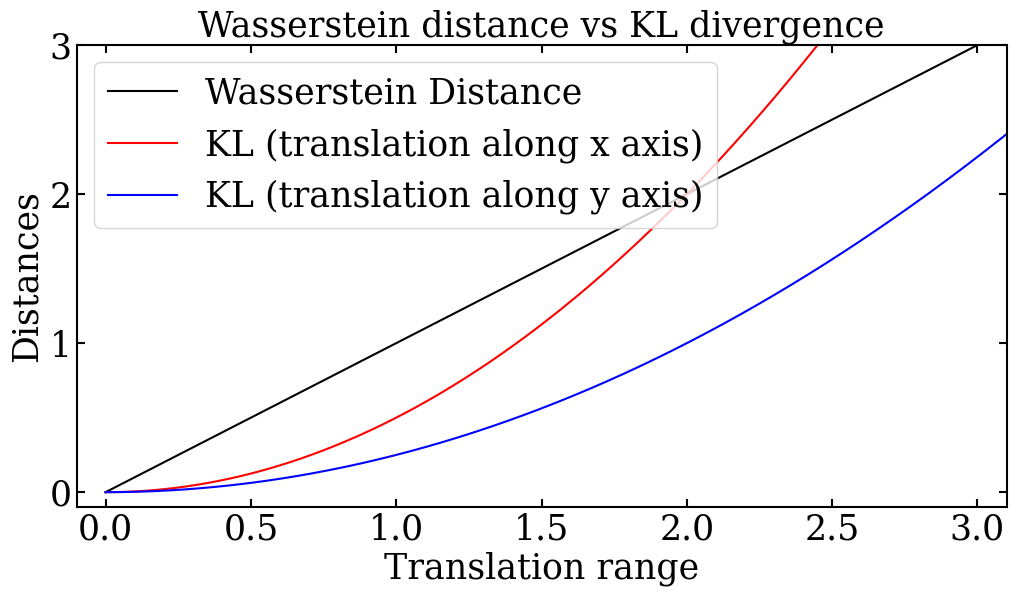

In [45]:
x = data.iloc[:, 0]
Wasserstein = data.iloc[:, 1]
KL_x = data.iloc[:, 2]
KL_y = data.iloc[:, 3]


fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(111)
ax.plot(x, Wasserstein, color='black', label = 'Wasserstein Distance')
ax.plot(x, KL_x, color='r', label = 'KL (translation along x axis)')
ax.plot(x, KL_y, color='b', label = 'KL (translation along y axis)')

ax.set_title(f"Wasserstein distance vs KL divergence", fontsize=25)
ax.set_xlabel('Translation range')
ax.set_ylabel('Distances')

#x軸の表示範囲を指定
ax.set_xlim(-0.1, 3.1)
ax.set_ylim(-0.1, 3)
ax.legend()
plt.show()

In [46]:
theta = np.linspace(0, 2*np.pi, linspace)

A = Cov_Matrix
R= np.array(
    [[np.cos(theta[i]),-1 *np.sin(theta[i])
    ,np.sin(theta[i]), np.cos(theta[i])] for i in range(linspace)]
).reshape(linspace,2,2)

A_inv = np.linalg.inv(A)
R_inv = np.linalg.inv(R)

sqrt_A = np.zeros_like(R)
for i in range(len(A)):
    sqrt_A[i] = sp.linalg.sqrtm(A[i])

matrix = sqrt_A@R@A@R_inv@sqrt_A
sqrt_matrix = np.zeros_like(matrix)
for i in range(len(matrix)):
    sqrt_matrix[i] = sp.linalg.sqrtm(matrix[i])
W = 2* np.trace(A - sqrt_matrix, axis1=1, axis2=2)

matrix = A@R@A_inv@R_inv
KL_trace = np.trace(matrix, axis1=1, axis2=2)
KL = 0.5*(KL_trace - 2)

data_rot = pd.DataFrame(data = {'rotation_theta':theta, 'Wasserstein':W, 'KL':KL})

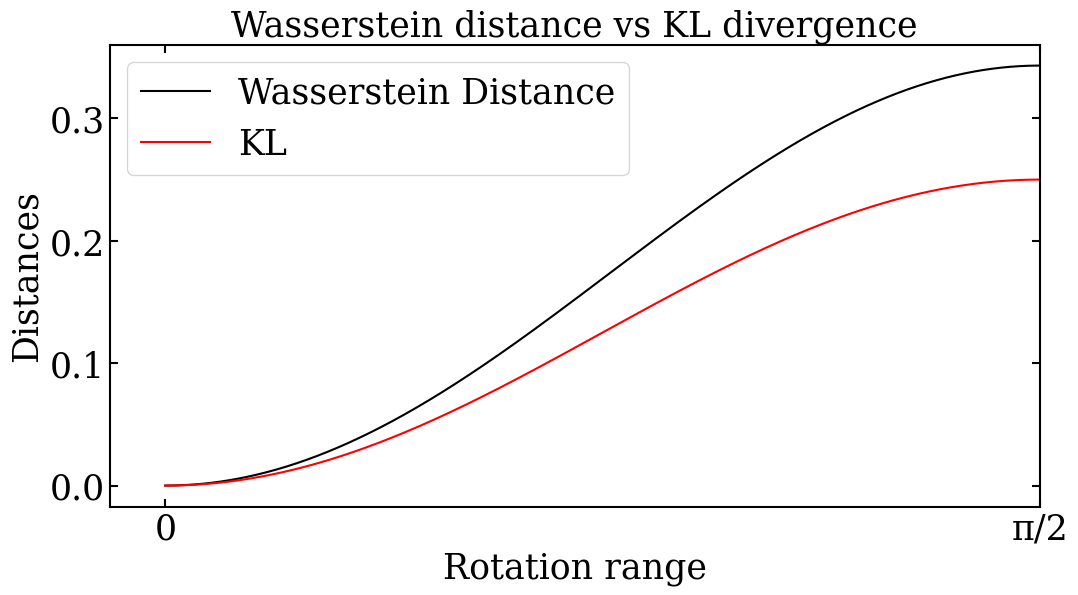

In [47]:
x = data_rot.iloc[:, 0]
Wasserstein = data_rot.iloc[:, 1]
KL = data_rot.iloc[:, 2]


fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(111)
ax.plot(x, Wasserstein, color='black', label = 'Wasserstein Distance')
ax.plot(x, KL, color='r', label = 'KL')


ax.set_title(f"Wasserstein distance vs KL divergence", fontsize=25)
ax.set_xlabel('Rotation range')
ax.set_ylabel('Distances')

ax.set_xticks([0, np.pi/2])
ax.set_xticklabels(["0", "π/2"])
ax.set_xlim(-0.1, 3.1416/2)
ax.legend()
plt.show()